In [1]:
import networkx as nx
from ema_workbench import load_results
import matplotlib.pyplot as plt
import pandas as pd
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
from SALib.analyze import sobol
import pickle
import seaborn as sns

/home/ana/Documents/Proyectos/microminer-eval/.venv/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


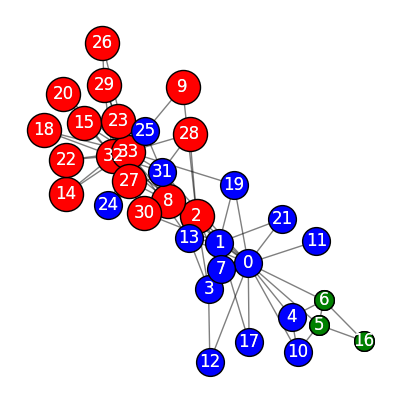

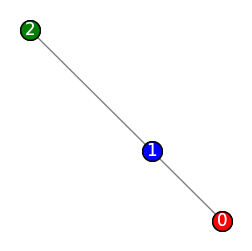

In [2]:
from cdlib import algorithms
from cdlib import viz

g = nx.karate_club_graph()
lp_coms = algorithms.label_propagation(g)

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5), plot_overlaps=True, plot_labels=True) #, top_k=2)
viz.plot_community_graph(g, lp_coms, figsize=(3, 3), plot_overlaps=False, plot_labels=True)
plt.show()

In [3]:
from sklearn_extra.cluster import KMedoids

# NOTEBOOK CONFIGURATION
PROJECT_NAME = "jpetstore"
PROJECT_PATH = "../jpetstore"

In [4]:
MODEL_FILENAME = f"{PROJECT_PATH}/{PROJECT_NAME}_128scenarios_nopolicies_sobol" #.tar.gz'

experiments_df, outcomes = load_results(MODEL_FILENAME+ '.tar.gz')
experiments_df['beta'] = 100 - experiments_df['alpha']
outcomes_df = pd.DataFrame(outcomes)
print(experiments_df.shape, outcomes_df.shape)

with open(MODEL_FILENAME+'_model.pkl', 'rb') as input:
    uncertainties_problem = pickle.load(input)
with open(MODEL_FILENAME+'_partitions.pkl', 'rb') as input:
    partitions_dict = pickle.load(input)
    print(len(partitions_dict.keys()), "clusters")

(1280, 8) (1280, 5)
1205 clusters


In [5]:
experiments_df.head()

,alpha,mfuzzy,microservice_threshold,resolution,scenario,policy,model,beta
0,54,5,10,40,0,NaN,jpetstore,46
1,88,5,10,40,1,NaN,jpetstore,12
2,54,4,10,40,2,NaN,jpetstore,46
3,54,5,9,40,3,NaN,jpetstore,46
4,54,5,10,52,4,NaN,jpetstore,46


In [6]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   alpha                   1280 non-null   int64   
 1   mfuzzy                  1280 non-null   int64   
 2   microservice_threshold  1280 non-null   int64   
 3   resolution              1280 non-null   int64   
 4   scenario                1280 non-null   category
 5   policy                  0 non-null      category
 6   model                   1280 non-null   category
 7   beta                    1280 non-null   int64   
dtypes: category(3), int64(5)
memory usage: 97.6 KB


In [7]:
experiments_df.describe()

,alpha,mfuzzy,microservice_threshold,resolution,beta
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,50.503906,6.019531,5.996094,50.511719,49.496094
std,28.879383,2.578632,2.581734,28.883712,28.879383
min,1.000000,2.000000,2.000000,1.000000,0.000000
25%,25.750000,4.000000,4.000000,25.750000,24.750000
50%,50.500000,6.000000,6.000000,50.500000,49.500000
75%,75.250000,8.000000,8.000000,75.250000,74.250000
max,100.000000,10.000000,10.000000,100.000000,99.000000


In [8]:
outcomes

{'n_partitions': array([7, 7, 7, ..., 7, 6, 7]),
 'modularity': array([-0.00525358, -0.00495338, -0.00926459, ..., -0.00421639,
        -0.00491912, -0.00421639]),
 'ned': array([0.913, 0.866, 0.816, ..., 1.   , 1.   , 1.   ]),
 'density': array([1.27162125, 1.28712061, 1.59795424, ..., 1.28880532, 1.25300518,
        1.28880532]),
 'noise_classes': array([17, 17, 17, ..., 17, 17, 17])}

In [9]:
outcomes_df.head()

,n_partitions,modularity,ned,density,noise_classes
0,7,-0.005254,0.913,1.271621,17
1,7,-0.004953,0.866,1.287121,17
2,7,-0.009265,0.816,1.597954,17
3,8,-0.004377,0.921,1.287811,17
4,8,-0.005725,0.684,1.298740,17


In [10]:
outcomes_df.describe()

,n_partitions,modularity,ned,density,noise_classes
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.0
mean,7.171875,-0.006163,0.932814,1.395193,17.0
std,0.795898,0.007271,0.125696,0.524789,0.0
min,5.000000,-0.075644,0.431000,0.859027,17.0
25%,7.000000,-0.004919,0.915000,1.286529,17.0
50%,7.000000,-0.004216,1.000000,1.288805,17.0
75%,8.000000,-0.004216,1.000000,1.315655,17.0
max,10.000000,-0.002951,1.000000,7.549820,17.0


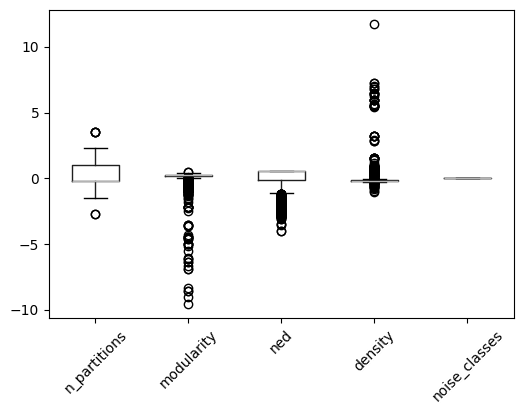

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
outcomes_scaled = scaler.fit_transform(outcomes_df)
outcomes_scaled_df = pd.DataFrame(outcomes_scaled, columns=outcomes_df.columns)

boxplot = outcomes_scaled_df.boxplot(grid=False, figsize=(6,4), rot=45)
plt.show()

In [12]:
df = pd.concat([experiments_df, outcomes_df], axis=1) #outcomes_df.copy()
#df['resolution'] = experiments_df['resolution']

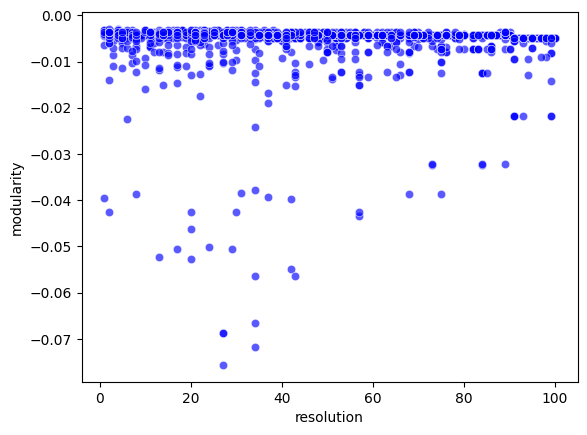

In [13]:
sns.scatterplot(data=df, x="resolution", y="modularity", alpha=0.65, color='blue')
plt.show()

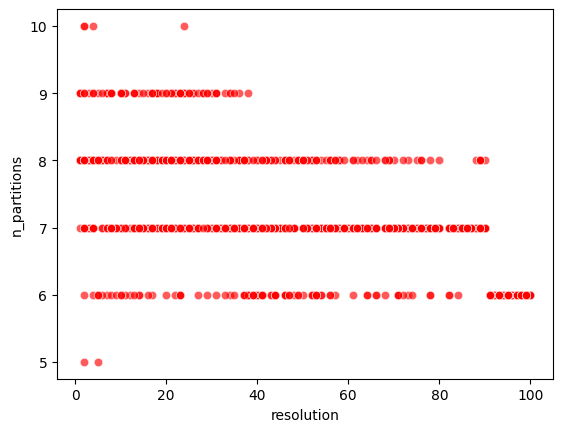

In [14]:
sns.scatterplot(data=df, x="resolution", y="n_partitions", alpha=0.65, color='red')
plt.show()

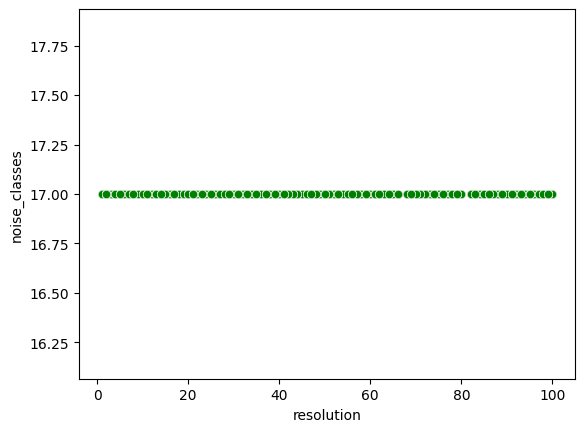

In [15]:
sns.scatterplot(data=df, x="resolution", y="noise_classes", alpha=0.65, color='green')
plt.show()

In [16]:
# Visualization of scenarios
def show_pairplot(experiments, outcomes, kind='sns', title='', group='scenario', filename=None):
    if kind == 'sns':
        data = pd.DataFrame(outcomes)
        policies = experiments['scenario']
        data['scenario'] = policies
        g = sns.pairplot(data, hue=group, vars=list(outcomes.keys()), corner=True, plot_kws={'alpha':0.25})
        g._legend.remove()
        g.fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()
    if kind == 'matplotlib':
        data = experiments.copy()
        data['scenario'] = experiments['scenario'].astype(str)
        fig, axes = pairs_plotting.pairs_scatter(data, outcomes, group_by=group,legend=False)
        fig.set_size_inches(8,8)
        fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()

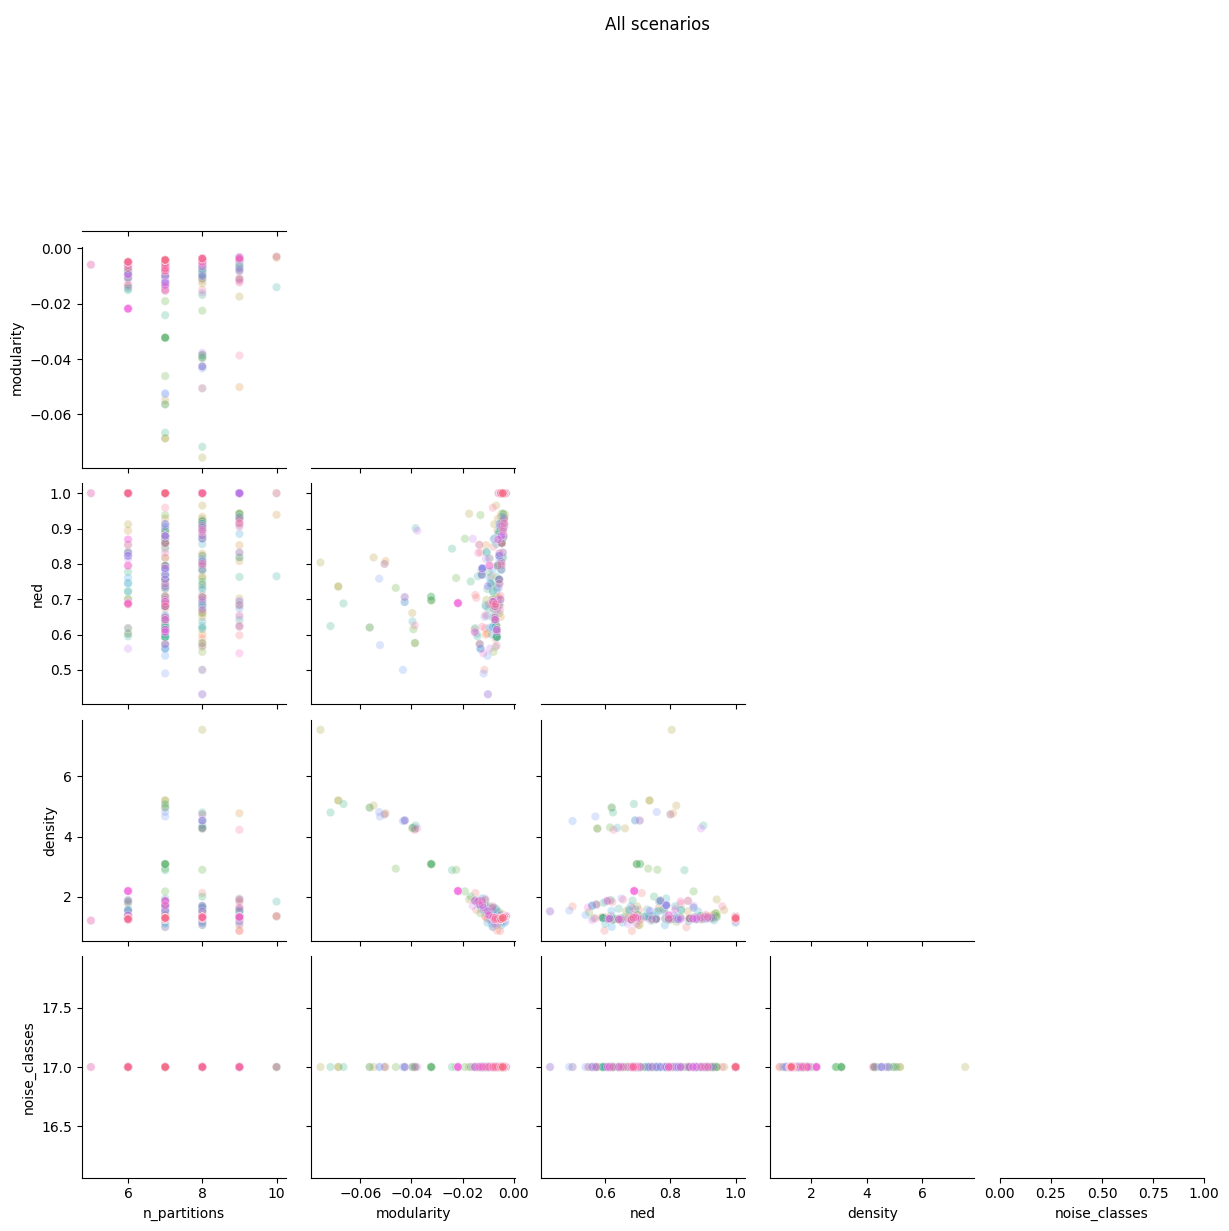

In [17]:
show_pairplot(experiments_df, outcomes, title='All scenarios', kind='sns')

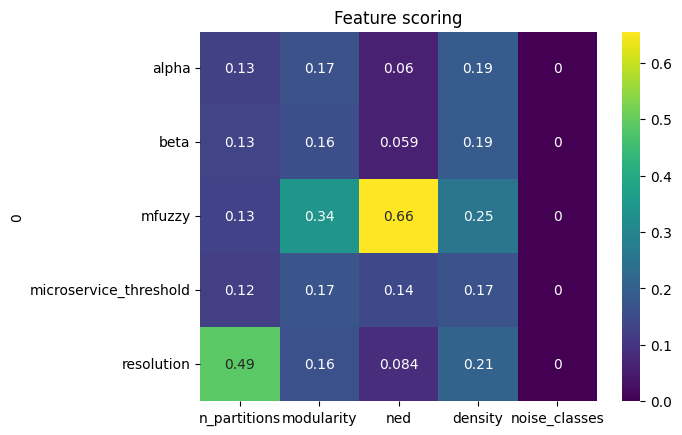

,n_partitions,modularity,ned,density,noise_classes
0,,,,,
alpha,0.126062,0.165653,0.060330,0.186757,0.0
beta,0.132268,0.157584,0.059079,0.186682,0.0
mfuzzy,0.130090,0.341905,0.655335,0.254388,0.0
microservice_threshold,0.122775,0.172800,0.141137,0.166635,0.0
resolution,0.488804,0.162058,0.084119,0.205538,0.0


In [18]:
fs = feature_scoring.get_feature_scores_all(experiments_df, outcomes) #, mode=feature_scoring.CLASSIFICATION)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.title('Feature scoring')
#plt.title('Feature scoring (jpetstore)')
#plt.savefig('feature-scoring-jpetstore.png')
#plt.title('Feature scoring (cargo)')
#plt.savefig('feature-scoring-cargo.png')
plt.show()
fs

In [19]:
# For parameters
# uncertainties_problem = get_SALib_problem(model.uncertainties)
print('----', 'n_partitions')
Si_1 = sobol.analyze(uncertainties_problem, outcomes['n_partitions'], calc_second_order=True, print_to_console=True)
print('----', 'modularity')
Si_2 = sobol.analyze(uncertainties_problem, outcomes['modularity'], calc_second_order=True, print_to_console=True)
print('----', 'ned')
ned = sobol.analyze(uncertainties_problem, outcomes['ned'], calc_second_order=True, print_to_console=True)
print('----', 'density')
density = sobol.analyze(uncertainties_problem, outcomes['density'], calc_second_order=True, print_to_console=True)
print('----', 'noise_classes')
Si_3 = sobol.analyze(uncertainties_problem, outcomes['noise_classes'], calc_second_order=True, print_to_console=True)

---- n_partitions
                              ST   ST_conf
alpha                   0.515321  0.151292
mfuzzy                  0.585303  0.175030
microservice_threshold  0.458063  0.140945
resolution              0.979746  0.225143
                              S1   S1_conf
alpha                  -0.056661  0.153380
mfuzzy                 -0.168195  0.132442
microservice_threshold -0.088670  0.125558
resolution              0.332016  0.250939
                                            S2   S2_conf
(alpha, mfuzzy)                       0.007952  0.229594
(alpha, microservice_threshold)       0.020676  0.230500
(alpha, resolution)                   0.033400  0.242950
(mfuzzy, microservice_threshold)      0.458660  0.278441
(mfuzzy, resolution)                  0.267800  0.261592
(microservice_threshold, resolution)  0.135590  0.253108
---- modularity
                              ST   ST_conf
alpha                   0.506674  0.924546
mfuzzy                  1.177449  1.127893
microser

In [20]:
def show_sobol(problem, Si, title='', filename=None):
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

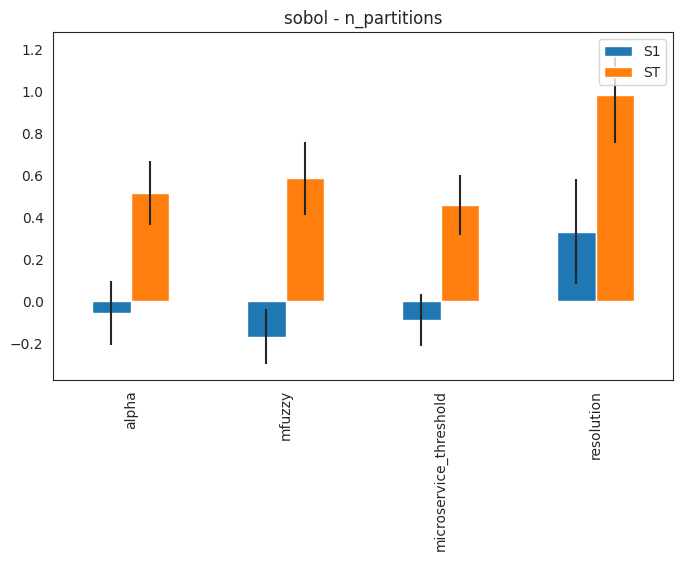

In [21]:
show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions')
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (jpetstore)', filename="sobol_n_partitions_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions (cargo)', filename="sobol_n_partitions_cargo.png")

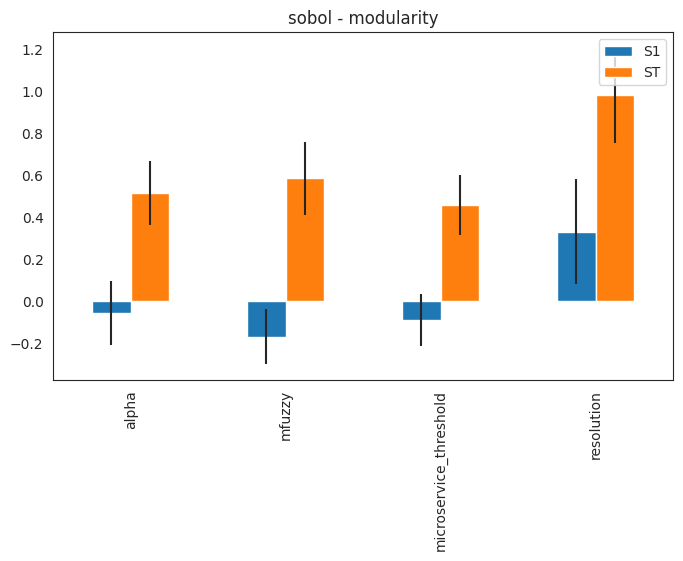

In [22]:
show_sobol(uncertainties_problem, Si_1, title='sobol - modularity')
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (jpetstore)', filename="sobol_modularity_jpetstore.png")
#show_sobol(uncertainties_problem, Si_1, title='sobol - modularity (cargo)', filename="sobol_modularity_cargo.png")

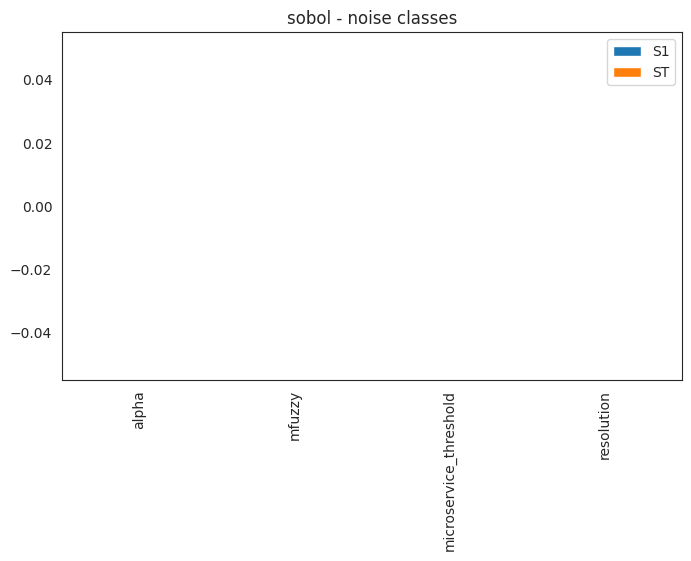

In [23]:
show_sobol(uncertainties_problem, Si_3, title='sobol - noise classes')
#show_sobol(uncertainties_problem, Si_3, title='sobol - modularity (jpetstore)', filename="sobol_noiseclasses_jpetstore.png")
#show_sobol(uncertainties_problem, Si_3, title='sobol - modularity (cargo)', filename="sobol_noiseclasses_cargo.png")

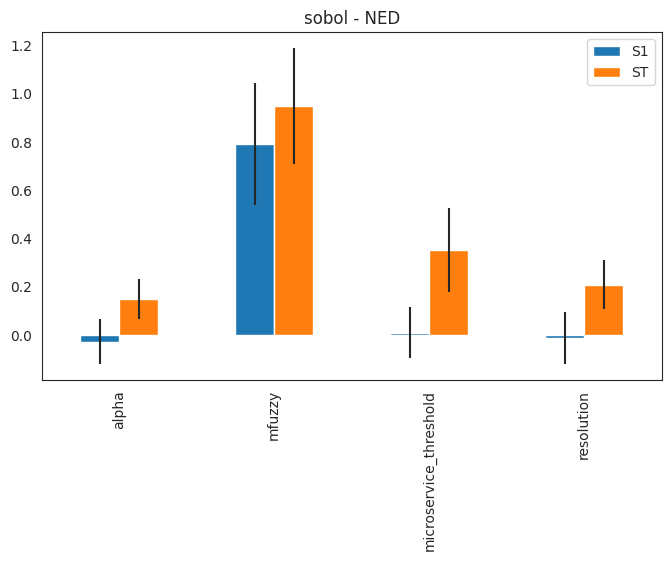

In [24]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

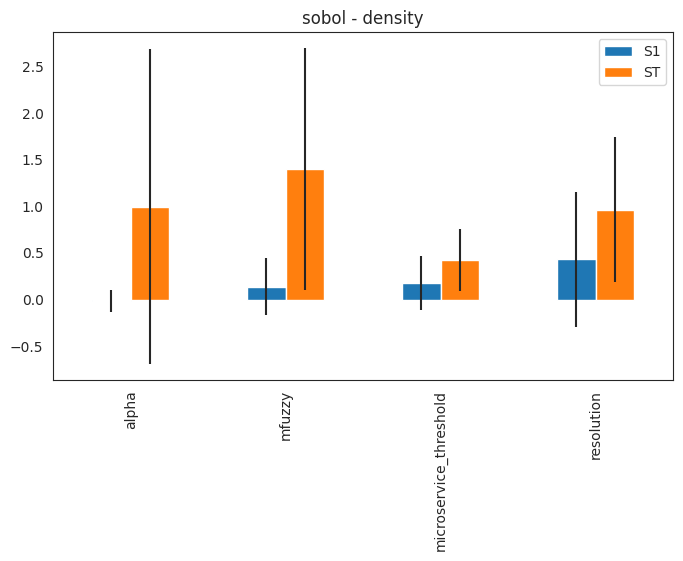

In [25]:
show_sobol(uncertainties_problem, density, title='sobol - density')

In [ ]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

In [ ]:
show_sobol(uncertainties_problem, density, title='sobol - density')

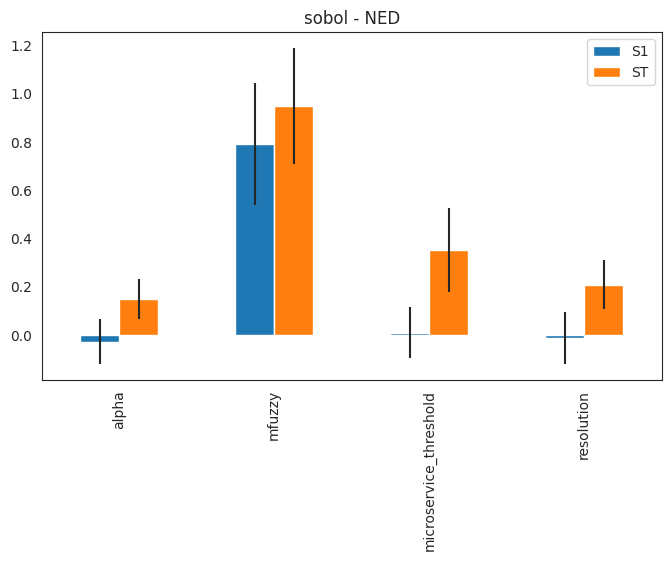

In [26]:
show_sobol(uncertainties_problem, ned, title='sobol - NED')

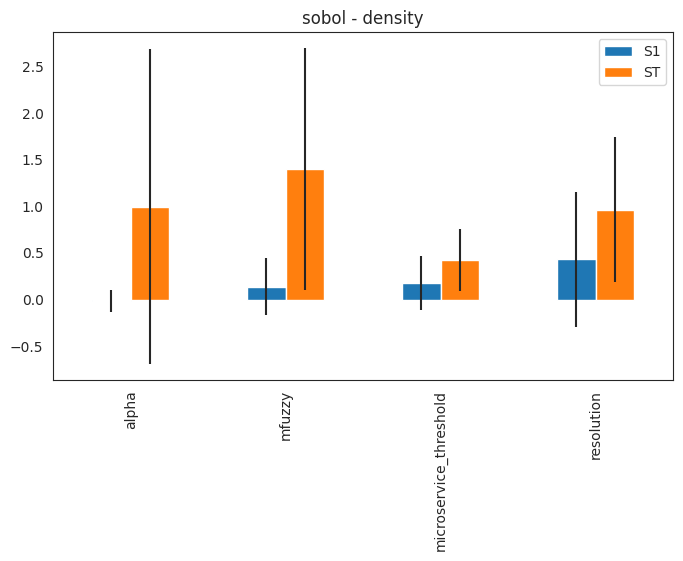

In [27]:
show_sobol(uncertainties_problem, density, title='sobol - density')